## Natural Language Processing (NLP) in Finance

This notebook provides an introduction to Natural Language Processing (NLP) applications in finance.
We will explore:

- **Text preprocessing** techniques for financial documents
- **Sentiment analysis** using dictionary-based methods
- **Performance evaluation** of NLP models
- **Financial document types** and their characteristics
- **N-gram analysis** focusing on negation patterns
- **Real-world applications** in financial markets


#### Required NLP Packages

This notebook uses several NLP specific Python packages:

**Core NLP Libraries:**
* **nltk** - Natural Language Toolkit for Python (https://www.nltk.org)
  - Text preprocessing, tokenization, and linguistic analysis
* **spaCy** - Industrial-strength NLP library (https://spacy.io)
  - Advanced text processing with pre-trained models
* **en_core_web_sm** - English language model for spaCy
  - Provides lemmatization, part-of-speech tagging, and named entity recognition

**Machine Learning & Analysis:**
* **scikit-learn** - Machine learning library with text vectorization capabilities
* **pandas & numpy** - Data manipulation and numerical computing
* **matplotlib & seaborn** - Data visualization
* **wordcloud** - Word cloud generation for text visualization


!python -m spacy==3.5.4
import spacy
!python -m spacy download en_core_web_sm

In [22]:
import pandas as pd
import numpy as np
import itertools
import re

# NLP Toolkits
import nltk
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer

# Gaphics packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [23]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justincase/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/justincase/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/justincase/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Financial Text Datasets

We'll work with two datasets for financial NLP:

**1. The Financial Phrase Bank** (Malo et al., 2014)
- **Description**: A collection of business and financial phrases manually annotated with sentiment scores
- **Size**: ~4,800 phrases with human-annotated sentiment labels
- **Labels**: Positive, Negative, Neutral
- **Use Case**: Benchmark dataset for evaluating sentiment analysis models
- **Download**: https://huggingface.co/datasets/financial_phrasebank/tree/main/data

**2. The Loughran-McDonald Master Dictionary** (1993-2024)
- **Description**: The gold standard dictionary for financial sentiment analysis
- **Categories**: Positive, Negative, Uncertainty, Litigious, Strong Modal, Weak Modal, Constraining
- **Coverage**: ~2,000+ words specifically relevant to financial and accounting texts
- **Use Case**: Dictionary-based sentiment analysis in finance
- **Download**: https://sraf.nd.edu/loughranmcdonald-master-dictionary/



In [24]:
df_phrases = pd.read_csv('Sentences_AllAgree.txt', delimiter='@', encoding='latin-1', on_bad_lines='skip', names=['Phrase', 'Sentiment'])
df_phrases.head()

,Phrase,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [25]:
df_dictionary = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2024.csv', delimiter=',', on_bad_lines='skip', header=0)
df_dictionary.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity,Syllables,Source
0,AARDVARK,1,755,2.955070e-08,1.945421e-08,4.078069e-06,140,0,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.174200e-10,8.060019e-12,8.919011e-09,1,0,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.522600e-10,1.089343e-10,5.105359e-08,7,0,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.135060e-09,6.197922e-10,1.539279e-07,28,0,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,9620,3.765268e-07,3.825261e-07,3.421836e-05,1295,0,0,0,0,0,0,0,0,3,12of12inf


### Text as Data: The Foundation of Financial NLP

In financial markets, text data is abundant and contains valuable information that can drive investment decisions. From earnings calls to social media posts, financial text data comes in various forms and requires specialized processing techniques.

**Key Characteristics of Financial Text:**
- **High information density**: Every word can impact market sentiment
- **Time-sensitive**: Information becomes stale quickly
- **Technical terminology**: Specialized vocabulary and concepts
- **Sentiment-driven**: Often contains emotional and opinion-based content

#### Text Preprocessing for Financial Data

Effective text preprocessing is crucial for financial NLP applications. The following function demonstrates a comprehensive preprocessing pipeline specifically designed for financial text:

**Preprocessing Steps:**

1. **Case Normalization**: Convert to lowercase for consistency
2. **Punctuation Removal**: Clean non-alphanumeric characters using regex
3. **Tokenization**: Split text into individual words using NLTK
4. **Stopword Removal**: Filter out common words that carry little meaning
5. **Lemmatization**: Reduce words to their base form using spaCy


In [26]:
def preprocess_text(text, stopwrds):
  filtered_tokens = []

  # Convert text to lowercase
  text = text.lower()

  # Remove punctuation and non-alphanumeric characters using regular expression
  text = re.sub(r'\W+', ' ', text)

  # Tokenize text using NLTK
  word_tokens = word_tokenize(text)

  # Remove stop words
  if stopwrds:
    filtered_tokens = [word for word in word_tokens if word not in stop_words]

    # Reconstruct the text without stop words
    text = ' '.join(filtered_tokens)

  # Use spaCy for lemmatization
  doc = nlp(text)
  lemmatized_text = " ".join([token.lemma_ for token in doc])

  return lemmatized_text

In [27]:
df_phrases['Pre_Processed'] = df_phrases['Phrase'].apply(lambda x: preprocess_text(x, True))
df_phrases['Pre_Processed_w_stopwords'] = df_phrases['Phrase'].apply(lambda x: preprocess_text(x, False))
df_phrases.head()

,Phrase,Sentiment,Pre_Processed,Pre_Processed_w_stopwords
0,"According to Gran , the company has no plans t...",neutral,accord gran company plan move production russi...,accord to gran the company have no plan to mov...
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale double e...,for the last quarter of 2010 componenta s net ...
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter 2010 net sale increase 5 2 eur 2...,in the third quarter of 2010 net sale increase...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,operating profit rise eur 13 1 mn eur 8 7 mn c...,operating profit rise to eur 13 1 mn from eur ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,operate profit total eur 21 1 mn eur 18 6 mn 2...,operate profit total eur 21 1 mn up from eur 1...


#### Bag of Words: Converting Text to Numbers

The Bag of Words (BoW) model is a fundamental technique for converting text data into numerical format that machine learning algorithms can process. This approach treats each document as a "bag" of words, ignoring word order but preserving frequency information.

**How Bag of Words Works:**
1. **Vocabulary Creation**: Build a vocabulary from all unique words in the corpus
2. **Vectorization**: Convert each document to a vector of word counts
3. **Matrix Formation**: Create a document-term matrix where:
   - Rows = documents (phrases)
   - Columns = vocabulary words
   - Values = word frequencies

**Key Components:**
- **CountVectorizer**: Scikit-learn's implementation for text vectorization
- **Document-Term Matrix**: Numerical representation of text data
- **Word Frequency Analysis**: Identify most common terms in the corpus

**Advantages:**
- Simple and interpretable
- Works well with traditional ML algorithms
- Preserves word frequency information

**Limitations:**
- Ignores word order and context
- High-dimensional sparse matrices
- Doesn't capture semantic relationships

In [28]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_phrases['Pre_Processed'])
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_sum = df_bow.sum(axis=0).sort_values(ascending=False)

print(df_bow.iloc[2000:2031, 1270:1275])

      community  companiesandmarket  company  comparable  comparative
2000          0                   0        0           0            0
2001          0                   0        1           0            0
2002          0                   0        0           0            0
2003          0                   0        0           0            0
2004          0                   0        0           0            0
2005          0                   0        0           0            0
2006          0                   0        0           0            0
2007          0                   0        0           0            0
2008          0                   0        0           0            0
2009          0                   0        0           0            0
2010          0                   0        1           0            0
2011          0                   0        0           0            0
2012          0                   0        1           0            0
2013          0     

#### Visualizing Word Frequencies

After creating the document-term matrix, we can visualize the most frequent words to understand the vocabulary and themes in our financial text corpus. This analysis helps identify:

- **Key financial terms** that appear frequently
- **Common sentiment words** in the dataset
- **Domain-specific vocabulary** patterns
- **Potential preprocessing issues** (e.g., unwanted terms)

**Visualization Techniques:**
1. **Bar Charts**: Show word frequencies in descending order
2. **Word Clouds**: Provide intuitive visual representation of term importance


/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_7984/551605047.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_sum[:25].values, y=word_sum[0:25].index, palette='viridis')


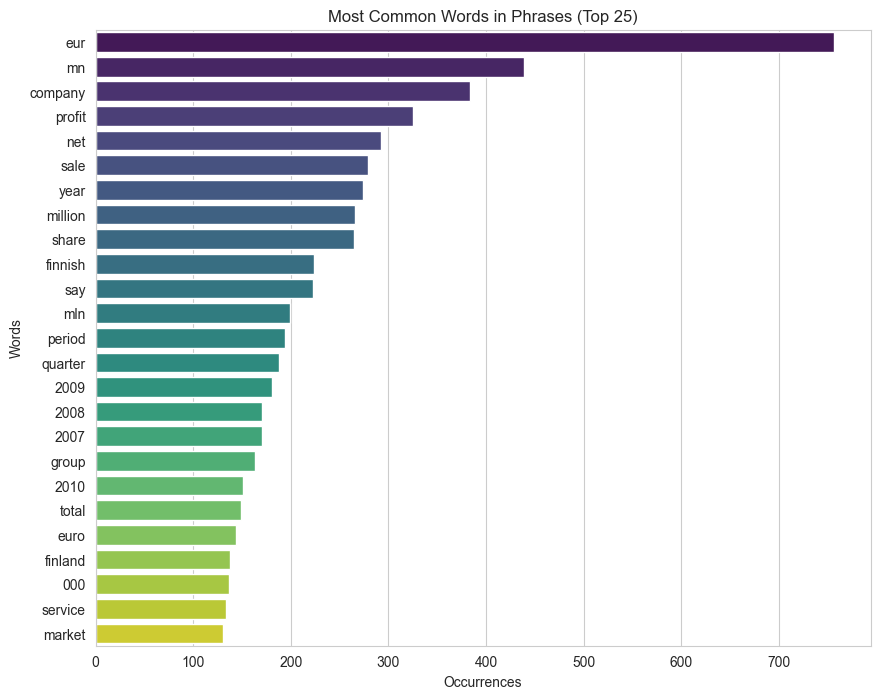

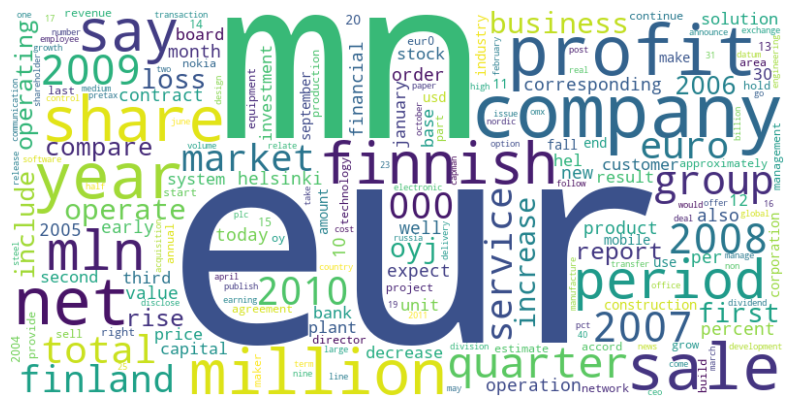

In [29]:
# Visualization - Barplot

plt.figure(figsize=(10, 8))
sns.barplot(x=word_sum[:25].values, y=word_sum[0:25].index, palette='viridis')
plt.title('Most Common Words in Phrases (Top 25)')
plt.xlabel('Occurrences')
plt.ylabel('Words')
plt.show()

print('\n')

# Visualization - Word cloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_sum)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment Analysis in Finance

Sentiment analysis is the process of determining the emotional tone or opinion expressed in text. In financial markets, sentiment analysis helps investors understand market mood, predict price movements, and make informed decisions.

**Dictionary-Based Sentiment Analysis:**
This approach uses predefined dictionaries of words with associated sentiment scores to classify text. We'll compare two approaches:
1. **Human Annotations**: Expert-labeled sentiment from the Financial Phrase Bank
2. **Loughran-McDonald Dictionary**: Automated sentiment scoring using financial word lists

**Why Dictionary-Based Methods Matter:**
- **Interpretable**: Easy to understand which words drive sentiment
- **Fast**: Quick computation without training
- **Domain-specific**: Loughran-McDonald is designed for financial text
- **Baseline**: Provides a benchmark for more complex methods

#### Building Sentiment Word Lists

To implement dictionary-based sentiment analysis, we need to extract and preprocess the sentiment words from the Loughran-McDonald dictionary:

**Process:**
1. **Extract Words**: Filter dictionary for positive and negative words
2. **Normalize**: Convert to lowercase for consistency
3. **Lemmatize**: Reduce to base forms for better matching
4. **Deduplicate**: Remove duplicate lemmatized forms

**Why Lemmatization Matters:**
- "increasing", "increased", "increases" → "increase"
- Ensures we capture all variations of sentiment words
- Improves matching accuracy in text analysis

In [30]:
negative_words = list(df_dictionary[df_dictionary['Negative'] > 0]['Word'].str.lower())
positive_words = list(df_dictionary[df_dictionary['Positive'] > 0]['Word'].str.lower())

positive_words[0:10]

['able',
 'abundance',
 'abundant',
 'acclaimed',
 'accomplish',
 'accomplished',
 'accomplishes',
 'accomplishing',
 'accomplishment',
 'accomplishments']

In [31]:
def lemma_words(word_lst):

  lemma_word_lst = []

  # Process each word with spaCy to obtain its lemma
  for word in word_lst:
    # Process the word to create a document object
    doc = nlp(word)
    # Since each 'word' is actually just one word, we can take the lemma of the first token
    lemmatized_word = doc[0].lemma_
    # Append the lemmatized word to the list
    lemma_word_lst.append(lemmatized_word)

  return list(set(lemma_word_lst))


positive_words = lemma_words(positive_words)
negative_words = lemma_words(negative_words)

for word in negative_words[:10]:
  print(word)

stressful
turbulence
irreparable
egregious
break
encumbrance
undeliverable
insolvent
coercion
demotion


#### Calculating Sentiment Scores

The Loughran-McDonald dictionary assigns sentiment scores by counting positive and negative words in each phrase:

**Scoring Method:**
- **Sentiment Score = Positive Words - Negative Words**
- **Positive Score**: More positive than negative words
- **Negative Score**: More negative than positive words  
- **Neutral Score**: Equal positive and negative words (or zero)

**Implementation:**
1. Tokenize each phrase into individual words
2. Count occurrences of positive words from our lemmatized list
3. Count occurrences of negative words from our lemmatized list
4. Calculate the difference as the sentiment score

**Advantages of This Approach:**
- Simple and interpretable
- Fast computation
- Provides continuous sentiment scores
- Easy to convert to categorical labels

In [32]:
def sentiment_difference(phrase):
  tokens = phrase.split()

  positive_count = sum(token in positive_words for token in tokens)
  negative_count = sum(token in negative_words for token in tokens)

  return positive_count - negative_count

df_phrases['LM_Sentiment'] = df_phrases['Pre_Processed_w_stopwords'].apply(sentiment_difference)

df_phrases

,Phrase,Sentiment,Pre_Processed,Pre_Processed_w_stopwords,LM_Sentiment
0,"According to Gran , the company has no plans t...",neutral,accord gran company plan move production russi...,accord to gran the company have no plan to mov...,0
1,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale double e...,for the last quarter of 2010 componenta s net ...,-1
2,"In the third quarter of 2010 , net sales incre...",positive,third quarter 2010 net sale increase 5 2 eur 2...,in the third quarter of 2010 net sale increase...,0
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,operating profit rise eur 13 1 mn eur 8 7 mn c...,operating profit rise to eur 13 1 mn from eur ...,0
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,operate profit total eur 21 1 mn eur 18 6 mn 2...,operate profit total eur 21 1 mn up from eur 1...,0
...,...,...,...,...,...
2259,Operating result for the 12-month period decre...,negative,operate result 12 month period decrease profit...,operate result for the 12 month period decreas...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative,helsinki thomson financial share cargotec fall...,helsinki thomson financial share in cargotec f...,-3
2261,LONDON MarketWatch -- Share prices ended lower...,negative,london marketwatch share price end low london ...,london marketwatch share price end lower in lo...,-1
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative,operating profit fall eur 35 4 mn eur 68 8 mn ...,operating profit fall to eur 35 4 mn from eur ...,1


#### Performance Evaluation: Loughran-McDonald vs. Human Annotations

Now let's evaluate how well the Loughran-McDonald dictionary performs compared to the human-annotated sentiment labels from the Financial Phrase Bank.


In [33]:
# Convert Loughran-McDonald sentiment scores to categorical labels
def convert_sentiment_score(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

df_phrases['LM_Prediction'] = df_phrases['LM_Sentiment'].apply(convert_sentiment_score)

# Check the distribution of predictions
print("Loughran-McDonald Predictions Distribution:")
print(df_phrases['LM_Prediction'].value_counts())
print("\nHuman Annotations Distribution:")
print(df_phrases['Sentiment'].value_counts())


Loughran-McDonald Predictions Distribution:
LM_Prediction
neutral     1716
negative     302
positive     246
Name: count, dtype: int64

Human Annotations Distribution:
Sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


Overall Accuracy: 0.621

Classification Report:
              precision    recall  f1-score   support

    negative       0.40      0.40      0.40       303
     neutral       0.68      0.84      0.75      1391
    positive       0.48      0.21      0.29       570

    accuracy                           0.62      2264
   macro avg       0.52      0.48      0.48      2264
weighted avg       0.59      0.62      0.59      2264



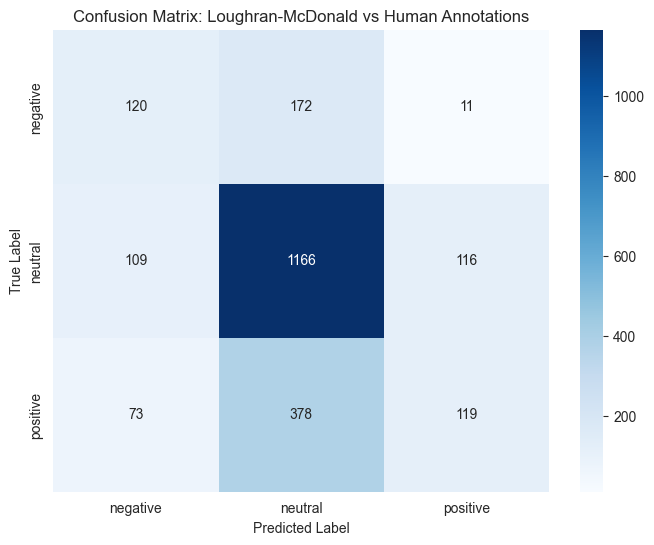

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(df_phrases['Sentiment'], df_phrases['LM_Prediction'])
print(f"Overall Accuracy: {accuracy:.3f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(df_phrases['Sentiment'], df_phrases['LM_Prediction']))

# Create confusion matrix
cm = confusion_matrix(df_phrases['Sentiment'], df_phrases['LM_Prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix: Loughran-McDonald vs Human Annotations')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [35]:
# Analyze misclassifications
misclassified = df_phrases[df_phrases['Sentiment'] != df_phrases['LM_Prediction']]

print(f"Number of misclassified examples: {len(misclassified)}")
print(f"Percentage misclassified: {len(misclassified)/len(df_phrases)*100:.1f}%")

# Show some examples of misclassifications
print("\nExamples of Misclassifications:")
print("="*50)
for i, row in misclassified.head(10).iterrows():
    print(f"Human: {row['Sentiment']} | LM: {row['LM_Prediction']} | Score: {row['LM_Sentiment']}")
    print(f"Text: {row['Phrase']}")
    print("-" * 50)


Number of misclassified examples: 859
Percentage misclassified: 37.9%

Examples of Misclassifications:
Human: positive | LM: negative | Score: -1
Text: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
--------------------------------------------------
Human: positive | LM: neutral | Score: 0
Text: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
--------------------------------------------------
Human: positive | LM: neutral | Score: 0
Text: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
--------------------------------------------------
Human: positive | LM: neutral | Score: 0
Text: Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .
-------

### Financial Document Types in NLP

Financial NLP applications span various document types, each with unique characteristics and preprocessing requirements. Let's examine examples of the most common financial text sources:


#### 1. Earnings Call Transcripts

Earnings calls are quarterly conference calls where company executives discuss financial results with analysts and investors. These contain:
- **Structured Q&A format** with prepared statements and spontaneous responses
- **Financial terminology** and specific metrics (EBITDA, revenue, guidance)
- **Forward-looking statements** and management commentary
- **Analyst questions** that reveal market expectations

**Example preprocessing considerations:**
- Remove speaker labels and timestamps
- Handle financial numbers and percentages
- Preserve question-answer structure
- Extract management vs. analyst segments


#### 2. Financial News Articles

Financial news articles from sources like Reuters, Bloomberg, and Wall Street Journal contain:
- **Objective reporting** with factual financial information
- **Market commentary** and expert opinions
- **Company-specific news** and industry analysis
- **Regulatory announcements** and policy changes

**Example preprocessing considerations:**
- Remove bylines and publication metadata
- Handle company tickers and stock symbols
- Preserve numerical data and dates
- Extract headlines and lead paragraphs


#### 3. Social Media Financial Content

Social media platforms like Twitter, Reddit, and StockTwits contain:
- **Informal language** with slang and abbreviations
- **Emotional expressions** and personal opinions
- **Hashtags and mentions** (#AAPL, @elonmusk)
- **Real-time market reactions** and sentiment

**Example preprocessing considerations:**
- Handle emojis and special characters
- Process hashtags and mentions
- Deal with informal spelling and abbreviations
- Filter spam and irrelevant content


### N-gram Analysis: Understanding Negation in Financial Text

N-grams (sequences of n consecutive words) are crucial for understanding context in financial text, especially negation patterns. In financial sentiment analysis, the presence of negation words can completely reverse the sentiment of a phrase.

**Why N-grams matter in financial NLP:**
- **Negation handling**: "not profitable" vs "profitable" have opposite sentiments
- **Context preservation**: "strong growth" vs "weak growth" 
- **Financial phrases**: "earnings beat" vs "earnings miss"
- **Temporal context**: "will increase" vs "has increased"


In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pandas as pd

# Create n-gram analyzer focusing on negation patterns
def analyze_negation_patterns(texts, ngram_range=(2, 2)):
    """
    Analyze n-grams with special focus on negation patterns in financial text
    """
    # Common negation words in financial context
    negation_words = [
        "no",
        "not",
        "none",
        "never",
        "without",
        "neither",
        "nor",
        "nothing",
        "nowhere",
        "nobody",
        "doesn't",
        "isn't",
        "wasn't",
        "aren't",
        "weren't",
        "won't",
        "can't",
        "couldn't",
        "shouldn't",
        "wouldn't",
        "didn't",
        "denied",
        "declined",
        "negative",
        "unavailable",
        "unauthorized",
        "unpaid",
        "uncollectible",
        "unrecoverable",
        "nonperforming",
        "nonpayment",
        "noncompliance",
        "nonexistent",
        "ineligible",
        "invalid",
        "insufficient",
        "impossible"
    ]
    
    # Create vectorizer for n-grams
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        stop_words='english',
        max_features=1000
    )
    
    # Fit and transform
    ngram_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Calculate n-gram frequencies
    ngram_counts = ngram_matrix.sum(axis=0).A1
    ngram_freq = dict(zip(feature_names, ngram_counts))
    
    # Filter for negation patterns
    negation_patterns = {}
    for ngram, count in ngram_freq.items():
        # Split n-gram into individual words and check for exact matches
        ngram_words = ngram.lower().split()
        if any(neg_word in ngram_words for neg_word in negation_words):
            negation_patterns[ngram] = count
    
    return negation_patterns, ngram_freq

# Analyze negation patterns in our financial phrases
negation_patterns, all_ngrams = analyze_negation_patterns(df_phrases['Pre_Processed'])

print("Top 20 Negation Patterns in Financial Phrases:")
print("="*50)
sorted_negations = sorted(negation_patterns.items(), key=lambda x: x[1], reverse=True)
for pattern, count in sorted_negations[:20]:
    print(f"{pattern}: {count}")


Top 20 Negation Patterns in Financial Phrases:
negative eur: 7
compare negative: 4


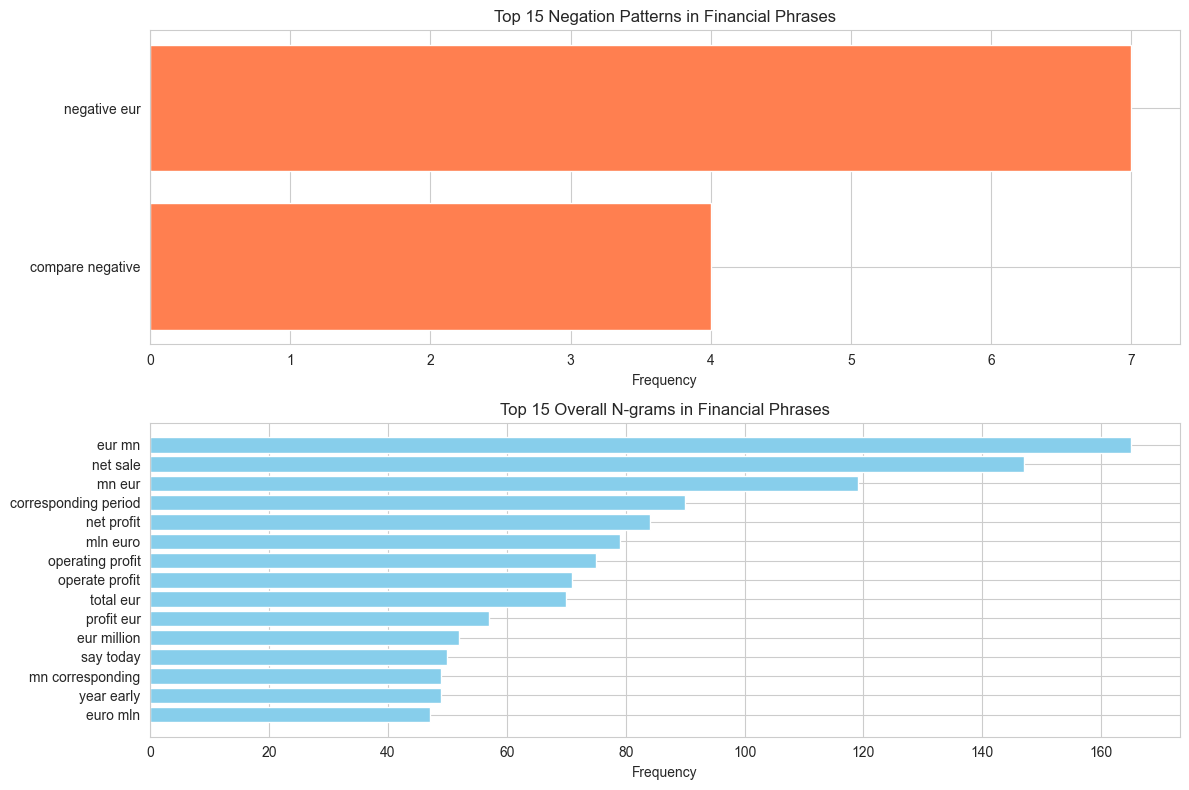

In [37]:
# Visualize negation patterns
plt.figure(figsize=(12, 8))

# Top 15 negation patterns
top_negations = dict(sorted_negations[:15])
patterns = list(top_negations.keys())
counts = list(top_negations.values())

plt.subplot(2, 1, 1)
plt.barh(range(len(patterns)), counts, color='coral')
plt.yticks(range(len(patterns)), patterns)
plt.xlabel('Frequency')
plt.title('Top 15 Negation Patterns in Financial Phrases')
plt.gca().invert_yaxis()

# Compare with overall n-gram frequencies
plt.subplot(2, 1, 2)
top_ngrams = dict(sorted(all_ngrams.items(), key=lambda x: x[1], reverse=True)[:15])
ngram_names = list(top_ngrams.keys())
ngram_counts = list(top_ngrams.values())

plt.barh(range(len(ngram_names)), ngram_counts, color='skyblue')
plt.yticks(range(len(ngram_names)), ngram_names)
plt.xlabel('Frequency')
plt.title('Top 15 Overall N-grams in Financial Phrases')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [38]:
# Analyze how negation affects sentiment classification
def analyze_negation_sentiment_impact(df):
    """
    Analyze how negation patterns affect sentiment classification accuracy
    """
    # Find phrases containing negation words
    negation_words = [
        "no",
        "not",
        "none",
        "never",
        "without",
        "neither",
        "nor",
        "nothing",
        "nowhere",
        "nobody",
        "doesn't",
        "isn't",
        "wasn't",
        "aren't",
        "weren't",
        "won't",
        "can't",
        "couldn't",
        "shouldn't",
        "wouldn't",
        "didn't",
        "denied",
        "declined",
        "negative",
        "unavailable",
        "unauthorized",
        "unpaid",
        "uncollectible",
        "unrecoverable",
        "nonperforming",
        "nonpayment",
        "noncompliance",
        "nonexistent",
        "ineligible",
        "invalid",
        "insufficient",
        "impossible"
    ]
    
    # Create negation indicator
    df['has_negation'] = df['Pre_Processed'].apply(
        lambda x: any(neg_word in x.lower().split() for neg_word in negation_words)
    )
    
    # Calculate accuracy for phrases with and without negation
    from sklearn.metrics import accuracy_score
    
    # Phrases without negation
    no_negation = df[~df['has_negation']]
    acc_no_neg = accuracy_score(no_negation['Sentiment'], no_negation['LM_Prediction'])
    
    # Phrases with negation
    with_negation = df[df['has_negation']]
    acc_with_neg = accuracy_score(with_negation['Sentiment'], with_negation['LM_Prediction'])
    
    return acc_no_neg, acc_with_neg, len(no_negation), len(with_negation)

# Analyze negation impact
acc_no_neg, acc_with_neg, count_no_neg, count_with_neg = analyze_negation_sentiment_impact(df_phrases)

print("Sentiment Classification Accuracy by Negation Presence:")
print("="*60)
print(f"Phrases without negation: {count_no_neg} examples")
print(f"Accuracy: {acc_no_neg:.3f}")
print(f"\nPhrases with negation: {count_with_neg} examples")
print(f"Accuracy: {acc_with_neg:.3f}")
print(f"\nAccuracy difference: {acc_no_neg - acc_with_neg:.3f}")

# Show some examples of misclassified negation phrases
negation_misclassified = df_phrases[(df_phrases['has_negation']) & 
                                   (df_phrases['Sentiment'] != df_phrases['LM_Prediction'])]

print(f"\nExamples of Misclassified Negation Phrases:")
print("="*50)
for i, row in negation_misclassified.head(5).iterrows():
    print(f"Human: {row['Sentiment']} | LM: {row['LM_Prediction']} | Score: {row['LM_Sentiment']}")
    print(f"Text: {row['Phrase']}")
    print("-" * 50)


Sentiment Classification Accuracy by Negation Presence:
Phrases without negation: 2245 examples
Accuracy: 0.620

Phrases with negation: 19 examples
Accuracy: 0.632

Accuracy difference: -0.011

Examples of Misclassified Negation Phrases:
Human: positive | LM: negative | Score: -1
Text: For example , net sales increased by 5.9 % from the first quarter , and EBITDA increased from a negative EUR 0.2 mn in the first quarter of 2009 .
--------------------------------------------------
Human: neutral | LM: negative | Score: -1
Text: Helsinki 19 May 2010 - Finnish company Lemminkainen Oyj ( HEL : LEM1S ) said today that it will construct an office building at Toolonlahti in downtown Helsinki , without disclosing financial details .
--------------------------------------------------
Human: positive | LM: negative | Score: -1
Text: Cash flow from business operations totalled EUR 0.4 mn compared to a negative EUR 15.5 mn in the first half of 2008 .
-----------------------------------------------

#### What empirical results are there regarding sentiment predicting returns?

* Tetlock, P. C. (2007). Giving content to investor sentiment: The role of media in the stock market. The Journal of Finance, 62(3), 1139–1168.

> https://www.jstor.org/stable/4622297
> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=685145


* Garcia, D. (2013). Sentiment during recessions. The Journal of Finance, 68(3), pp. 1267-1300


> https://www.jstor.org/stable/42002620
> https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1571101


* Birru, J., & Young, T. (2022). Sentiment and uncertainty. Journal of Financial Economics, 146(3), 1148–1169.

> https://www.sciencedirect.com/science/article/abs/pii/S0304405X2200112X



#### What about media other than newspapers?

* Das, S. R., & Chen, M. Y. (2007). Yahoo! for Amazon: Sentiment Extraction from Small Talk on the Web. Management Science, 53(9), 1375–1388.

> https://www.jstor.org/stable/20122297

* Hailiang Chen, Prabuddha De, Yu Jeffrey Hu, & Byoung-Hyoun Hwang. (2014). Wisdom of crowds: the value of stock opinions transmitted through social media. The Review of Financial Studies.


> https://doi.org/10.1093/rfs/hhu001
